<a href="https://colab.research.google.com/github/denozavrus/Python-Data-Science/blob/V2/Segmentation_of_roads_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
pip install -U albumentations

     |████████████████████████████████| 102 kB 5.2 MB/s 
     |████████████████████████████████| 47.8 MB 1.0 MB/s 
  Attempting uninstall: albumentations
    Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12


In [3]:
pip install segmentation-models-pytorch

     |████████████████████████████████| 88 kB 3.8 MB/s 
     |████████████████████████████████| 376 kB 36.2 MB/s 
     |████████████████████████████████| 58 kB 602 kB/s 
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.6.3-py3-none-any.whl size=12421 sha256=0ea0c3add39b12b922bf978dd70fca857c25b7d38061a460112c29240c9bb59f
  Stored in directory: /root/.cache/pip/wheels/90/6b/0c/f0ad36d00310e65390b0d4c9218ae6250ac579c92540c9097a
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60965 sha256=fc59abcfbef22dc73ba6bc00c3d8ea19dea2af46acd58e9852be7ba511abfeb5
  Stored in directory: /root/.cache/pip/wheels/ed/27/e8/9543d42de2740d3544db96aefef63bda3f2c1761b3334f4873
Successfully built efficientnet-pytorch pretrainedmodels


In [4]:
pip install torchx

     |████████████████████████████████| 154 kB 5.3 MB/s 
     |████████████████████████████████| 146 kB 33.1 MB/s 
     |████████████████████████████████| 134 kB 44.7 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 54 kB 2.2 MB/s 
  Created wheel for docstring-parser: filename=docstring_parser-0.8.1-py3-none-any.whl size=19679 sha256=8503b8b84d7d99cef954dd3964b7648697b6399b42b94838a7ec5685aa7f52e0
  Stored in directory: /root/.cache/pip/wheels/64/11/a5/143eba02bbc268191378c202be131d94b59ca40270bd49dd43
Successfully built docstring-parser


In [5]:
pip install catalyst

     |████████████████████████████████| 444 kB 5.3 MB/s 
     |████████████████████████████████| 65 kB 2.8 MB/s 
     |████████████████████████████████| 125 kB 33.6 MB/s 


In [6]:
pip uninstall opencv-python

Found existing installation: opencv-python 4.1.2.30
Uninstalling opencv-python-4.1.2.30:
  Would remove:
    /usr/local/lib/python3.7/dist-packages/cv2/*
    /usr/local/lib/python3.7/dist-packages/opencv_python-4.1.2.30.dist-info/*
  Would not remove (might be manually added):
    /usr/local/lib/python3.7/dist-packages/cv2/config-3.py
    /usr/local/lib/python3.7/dist-packages/cv2/config.py
    /usr/local/lib/python3.7/dist-packages/cv2/cv2.abi3.so
    /usr/local/lib/python3.7/dist-packages/cv2/gapi/__init__.py
    /usr/local/lib/python3.7/dist-packages/cv2/load_config_py2.py
    /usr/local/lib/python3.7/dist-packages/cv2/load_config_py3.py
    /usr/local/lib/python3.7/dist-packages/cv2/mat_wrapper/__init__.py
    /usr/local/lib/python3.7/dist-packages/cv2/misc/__init__.py
    /usr/local/lib/python3.7/dist-packages/cv2/misc/version.py
    /usr/local/lib/python3.7/dist-packages/cv2/utils/__init__.py
    /usr/local/lib/python3.7/dist-packages/cv2/version.py
Proceed (y/n)? y
  Successfull

In [7]:
pip install opencv-contrib-python==3.4.2.17

     |████████████████████████████████| 30.6 MB 1.9 MB/s 
  Attempting uninstall: opencv-contrib-python
    Found existing installation: opencv-contrib-python 4.1.2.30
    Uninstalling opencv-contrib-python-4.1.2.30:
      Successfully uninstalled opencv-contrib-python-4.1.2.30


In [8]:
import numpy as np 
import cv2 
import matplotlib.pyplot as plt

import os 
import glob
import re

import torch
import torch.nn as nn
from torch.utils.data import Dataset
import albumentations as A
from torchvision import transforms as T
from albumentations.pytorch.transforms import ToTensorV2
from torch.optim import Adam

import segmentation_models_pytorch as smp

import torchx
from catalyst import dl
from catalyst import metrics
from torch.optim.lr_scheduler import ReduceLROnPlateau


from catalyst.utils import set_global_seed

%matplotlib inline

In [9]:
SEED = 42

np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
set_global_seed(SEED)

In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [11]:
torch.cuda.empty_cache()

In [12]:
torch.cuda.memory_allocated(device)

0

## Get files

In [13]:
PATH_TO_IMGS = '/content/drive/MyDrive/Roads dataset/Custom dataset/images'
cwd = os.getcwd()

In [14]:
PATH_TO_MSKS = '/content/drive/MyDrive/Roads dataset/Custom dataset/masks'

In [15]:
def get_reg(string):
    
    def pad_pattern(patt, string):
        inds =[m.start() for m in re.finditer(f'\\{patt}', string)]
        
        for i in inds: 
            string = string[:i] + '\\' + string[i:]
        return string 
    
    string = pad_pattern("(", string)
    string = pad_pattern(")", string)
    
    return string 

In [16]:
def read_images(path_img, path_masks):
    images = []
    masks = []
    
    list_of_imgs = os.listdir(os.path.join(cwd, path_img))
    masks_names = [f for f in os.listdir(path_masks) if re.search(r'.*color_mask\..*', f)]
    
    for file in list_of_imgs: 
        
        r = re.compile(fr'.*{get_reg(file[:-4])}_.*')
        list_of_masks = list(filter(r.match, masks_names))
        if len(list_of_masks) != 1:
            print (file)
            return 0
        
        image_src = os.path.join(path_img, file)
        image = cv2.imread(image_src)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        images.append(image)
        
        mask_src = os.path.join(path_masks, list_of_masks[0])
        mask = cv2.imread(mask_src, cv2.IMREAD_GRAYSCALE)
        
#         thresh = 200
        
        (thresh, mask_bin) = cv2.threshold(mask, 110, 255, cv2.THRESH_BINARY)
        
#         im_bw = cv2.threshold(mask, thresh, 255, cv2.THRESH_BINARY)[1]
#         sums = np.sum(mask, axis = 2)
#         msk = (sums > 400).astype(int)
        masks.append(mask_bin/255.0)
    
    return images, masks

In [17]:
images, masks = read_images(PATH_TO_IMGS, PATH_TO_MSKS)

In [18]:
len(images)

1213

In [19]:
len(masks)

1213

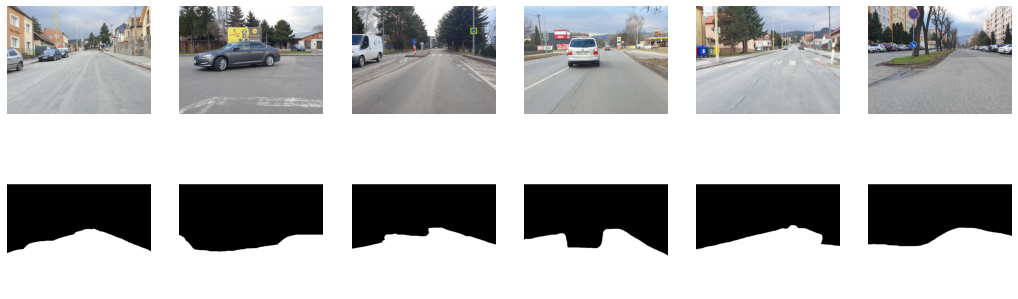

In [20]:
plt.figure(figsize=(18, 6))

for i in range(6):
    plt.subplot(2, 6, i+1)
    plt.axis("off")
    plt.imshow(images[i])

    plt.subplot(2, 6, i+7)
    plt.axis("off")
    plt.imshow(masks[i], 'gray')
    
plt.show()

## Create dataset

In [21]:
mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]


t_train = A.Compose([A.Resize(480, 640, p = 1), A.HorizontalFlip(), A.Rotate(limit = 20),
                     
                     A.OneOf(
                        [
                            A.MotionBlur(blur_limit=3, p=0.7),
                            A.Blur(blur_limit=3, p=0.7),
                        ],
                        p=0.5,
                    ),
                    A.RandomBrightnessContrast(
                        brightness_limit=0.1, contrast_limit=0.1, p=0.5)
                    ])

t_val = A.Resize(480, 640, p = 1)
t_test = A.Compose([A.Resize(480, 640, p = 1), A.Normalize(mean, std), ToTensorV2()])
t_test_orig = A.Resize(480, 640, p = 1)

In [22]:
class SegmentationDataset(Dataset):
    
    def __init__(self, images=None, masks=None, transforms=None, mean=None, std=None):
        self.images = images
        self.masks = masks
        self.transforms = transforms
        self.mean = mean
        self.std = std

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx: int):
        
        post_transform = A.Compose([A.Normalize(self.mean, self.std), ToTensorV2()])
        image = self.images[idx]
        
        result = {"image": image}
        
        if self.masks is not None:
            result["mask"] = self.masks[idx]
        
        if self.transforms is not None:
            result = self.transforms(image = result['image'], mask = result['mask'])
        
        result = post_transform(image = result['image'], mask = result['mask'])

        result['mask'] = result['mask'][np.newaxis,:,:]
        
        return result['image'], result['mask']

In [23]:
train_part = 0.75
valid_part = 0.90

indexes = np.arange(len(images))
np.random.shuffle(indexes)
train_indexes = indexes[:int(train_part * len(images))].astype(int)
valid_indexes = indexes[int(train_part * len(images)):int(valid_part * len(images))].astype(int)
test_indexes = indexes[int(valid_part * len(images)):].astype(int)

In [24]:
images = np.array(images)
masks = np.array(masks)

In [25]:
train_dataset = SegmentationDataset(
        images[train_indexes], masks[train_indexes], t_train, mean, std
    )

validation_dataset = SegmentationDataset(
        images[valid_indexes], masks[valid_indexes], t_val, mean, std
    )

test_dataset = SegmentationDataset(
        images[test_indexes], masks[test_indexes], t_val, mean, std
    )

In [26]:
from torch.utils.data import DataLoader

batch_size = 8

train_loader = DataLoader(
    train_dataset, 
    batch_size=batch_size,
    shuffle=True,
)

valid_loader = DataLoader(
    validation_dataset,
    batch_size=batch_size,
    shuffle=False,
)

test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
)

In [27]:
batch = next(iter(train_loader))

In [28]:
batch[0].shape

torch.Size([8, 3, 480, 640])

In [29]:
batch[1].shape

torch.Size([8, 1, 480, 640])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


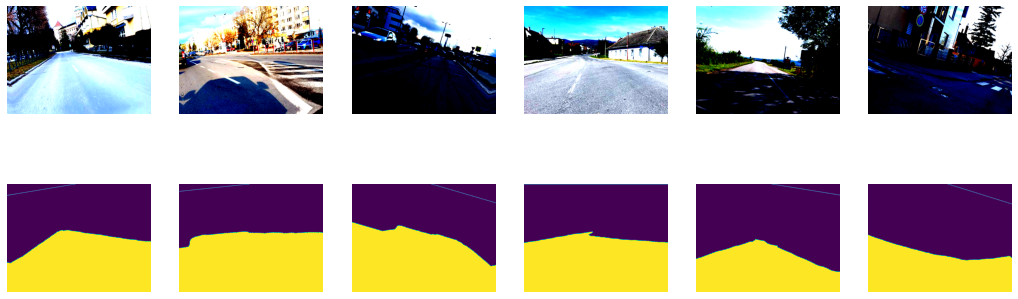

In [30]:
plt.figure(figsize=(18, 6))

for i in range(6):
    plt.subplot(2, 6, i+1)
    plt.axis("off")
    img = batch[0][i].permute(1, 2, 0).numpy()
    plt.imshow(img)

    plt.subplot(2, 6, i+7)
    plt.axis("off")
    plt.imshow(batch[1][i][0, :, :])
    
plt.show()

## Build model

In [ ]:
model = smp.UnetPlusPlus(
    encoder_name="efficientnet-b1",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
    in_channels=3,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=1,                    # model output channels (number of classes in your dataset)
)

In [ ]:
model

In [ ]:
model = model.to(device)

In [32]:
torch.cuda.memory_allocated(device)

0

## Learning 

In [31]:
del images, masks

In [32]:
import torch.nn.functional as F

In [33]:
class DiceLoss_Custom(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceLoss_Custom, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = torch.sigmoid(inputs)       
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        intersection = (inputs * targets).sum()                            
        dice = (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)
        
        return 1 - dice

In [34]:
class CustomIOUMetric(metrics.ICallbackBatchMetric, metrics.AdditiveMetric):
    def update(self, scores: torch.Tensor, targets: torch.Tensor) -> float:
        inputs = torch.sigmoid(scores)
        smooth=1

        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        intersection = (inputs * targets).sum()
        total = (inputs + targets).sum()
        union = total - intersection 

        IoU = (intersection + smooth)/(union + smooth)

        return IoU
    
    def update_key_value(self, scores: torch.Tensor, targets: torch.Tensor):
        value = self.update(scores, targets)
        return {"IOU": value}

    def compute_key_value(self):
        mean, std = super().compute()
        return {"IOU": mean, "IOU/std": std}

In [ ]:
criterion = DiceLoss_Custom()
optimizer = Adam(model.parameters(), lr = 0.0001)
scheduler = ReduceLROnPlateau(optimizer, 'min', patience = 5)
loaders = {
    "train": train_loader,
    # "train": train_loader_Kitti,
    "valid": valid_loader,
    # "valid": valid_loader_Kitti,
}
num_epochs = 100

NameError: ignored

In [ ]:
runner = dl.SupervisedRunner(input_key="features", output_key="outputs", target_key="targets", loss_key="loss")

In [ ]:
runner.train(
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    loaders=loaders,
    num_epochs=num_epochs,
    scheduler=scheduler,
    verbose=True, 
    callbacks=[
        dl.BatchMetricCallback(metric=CustomIOUMetric(), log_on_batch=True, input_key="outputs", target_key="targets"),
        dl.EarlyStoppingCallback(patience=10, loader_key = "valid", metric_key="loss", minimize=True)
    ],
    valid_loader="valid",
    valid_metric="loss",
    logdir="./checkpoints",
    minimize_valid_metric=True
)

1/100 * Epoch (train):   0%|          | 0/114 [00:00<?, ?it/s]

Keyboard Interrupt


KeyboardInterrupt: ignored

In [ ]:
torch.save(model.state_dict(), 'weights.pth')

In [ ]:
from catalyst import utils

In [ ]:
checkpoint = utils.pack_checkpoint(model=model)

In [ ]:
utils.save_checkpoint(checkpoint, path="./checkpoint")

In [ ]:
from google.colab import files
files.download("/content/weights.pth")

In [ ]:
files.download("/content/checkpoint")

In [ ]:
torch.cuda.empty_cache()

In [ ]:
model = smp.PSPNet(
    encoder_name="efficientnet-b1",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
    in_channels=3,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=1,                    # model output channels (number of classes in your dataset)
)

In [ ]:
model = smp.Unet(
    encoder_name="efficientnet-b1",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
    in_channels=3,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=1,                    # model output channels (number of classes in your dataset)
)

In [ ]:
model = smp.DeepLabV3Plus(
    encoder_name="efficientnet-b1",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
    in_channels=3,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=1,                    # model output channels (number of classes in your dataset)
)

In [35]:
model = smp.UnetPlusPlus(
    encoder_name="efficientnet-b1",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
    in_channels=3,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=1,                    # model output channels (number of classes in your dataset)
)

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b1-f1951068.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b1-f1951068.pth


  0%|          | 0.00/30.1M [00:00<?, ?B/s]

##Тест полученной модели

In [36]:
runner = dl.SupervisedRunner(input_key="features", output_key="outputs", target_key="targets", loss_key="loss")

In [37]:
from catalyst import utils

In [39]:
checkpoint = utils.load_checkpoint(path="/content/checkpoint_Unet++")

In [40]:
utils.unpack_checkpoint(
    checkpoint=checkpoint,
    model=model
)

In [41]:
model.eval()

UnetPlusPlus(
  (encoder): EfficientNetEncoder(
    (_conv_stem): Conv2dStaticSamePadding(
      3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
      (static_padding): ZeroPad2d(padding=(0, 1, 0, 1), value=0.0)
    )
    (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
    (_blocks): ModuleList(
      (0): MBConvBlock(
        (_depthwise_conv): Conv2dStaticSamePadding(
          32, 32, kernel_size=(3, 3), stride=[1, 1], groups=32, bias=False
          (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
        )
        (_bn1): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
        (_se_reduce): Conv2dStaticSamePadding(
          32, 8, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_se_expand): Conv2dStaticSamePadding(
          8, 32, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
  

In [42]:
model = model.to(device)

In [43]:
loaders_test = {'valid' : test_loader}

In [44]:
criterion = DiceLoss_Custom()
optimizer = Adam(model.parameters(), lr = 0.0001)

In [45]:
runner.train(
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    loaders=loaders_test,
    num_epochs=1,
    verbose=True, 
    callbacks=[
        dl.BatchMetricCallback(metric=CustomIOUMetric(), log_on_batch=True, input_key="outputs", target_key="targets"),
        dl.EarlyStoppingCallback(patience=10, loader_key = "valid", metric_key="loss", minimize=True)
    ],
    valid_loader="valid",
    valid_metric="loss",
    logdir="./checkpoints"
)

1/1 * Epoch (valid):   0%|          | 0/16 [00:00<?, ?it/s]

valid (1/1) IOU: nan | IOU/std: nan | loss: 0.008527111962251588 | loss/mean: 0.008527111962251588 | loss/std: 0.0036299713890509443 | lr: 0.0001 | momentum: 0.9
* Epoch (1/1) 
Top models:
./checkpoints/checkpoints/model.0001.pth	1.0000


In [46]:
batch = next(iter(test_loader))

In [47]:
images = batch[0]
masks = batch[1]

In [48]:
images = images.to(device)

In [49]:
masks.shape

torch.Size([8, 1, 480, 640])

In [50]:
%%time
preds = model.forward(images.to(device))

CPU times: user 44.2 ms, sys: 49.5 ms, total: 93.7 ms
Wall time: 98.2 ms


In [51]:
preds.shape

torch.Size([8, 1, 480, 640])

In [52]:
preds[0]

tensor([[[ 2.2192,  5.8414,  8.1528,  ...,  8.6923,  5.5368,  2.0997],
         [-5.2777, -6.1545, -6.6530,  ..., -4.9883, -3.9119, -2.7618],
         [-7.1213, -9.0832, -8.6705,  ..., -8.5842, -5.9327, -3.2931],
         ...,
         [ 6.4752,  9.0438,  9.5274,  ..., 11.3574, 10.3115,  6.5180],
         [ 6.1983,  9.0086, 10.5008,  ..., 11.8392, 10.5194,  6.2128],
         [ 3.8532,  6.6741,  8.9223,  ..., 10.4429,  9.1035,  4.9503]]],
       device='cuda:0', grad_fn=<SelectBackward0>)

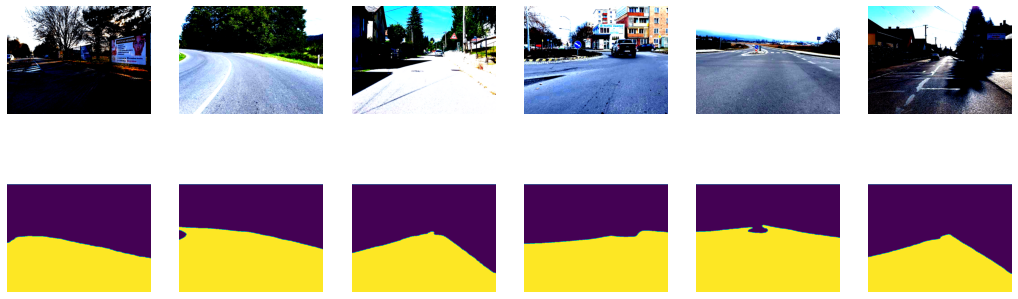

In [53]:
plt.figure(figsize=(18, 6))

for i in range(6):
    plt.subplot(2, 6, i+1)
    plt.axis("off")
    img = images.cpu().detach()[i].permute(1, 2, 0).numpy()
    plt.imshow(img)

    plt.subplot(2, 6, i+7)
    plt.axis("off")
    plt.imshow((preds>0.5).int().cpu().detach()[i][0, :, :])
    
plt.show()

In [54]:
torch.cuda.empty_cache()

In [55]:
image = cv2.imread('/content/000032_10.png')
# image_orig = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

In [56]:
image_copy = torch.unsqueeze(t_test(image = image)['image'], dim = 0)
image_orig = t_test_orig(image = image)['image']

In [57]:
torch.cuda.empty_cache()

In [60]:
model.to(device)

UnetPlusPlus(
  (encoder): EfficientNetEncoder(
    (_conv_stem): Conv2dStaticSamePadding(
      3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
      (static_padding): ZeroPad2d(padding=(0, 1, 0, 1), value=0.0)
    )
    (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
    (_blocks): ModuleList(
      (0): MBConvBlock(
        (_depthwise_conv): Conv2dStaticSamePadding(
          32, 32, kernel_size=(3, 3), stride=[1, 1], groups=32, bias=False
          (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
        )
        (_bn1): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
        (_se_reduce): Conv2dStaticSamePadding(
          32, 8, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_se_expand): Conv2dStaticSamePadding(
          8, 32, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
  

In [61]:
with torch.no_grad():
  image_copy = image_copy.to(device)
  preds = model.forward(image_copy)
  preds = (preds > 0.5).int().cpu().detach()

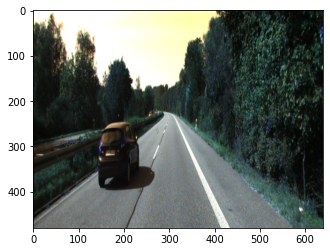

In [62]:
plt.imshow(image_orig)
plt.show()

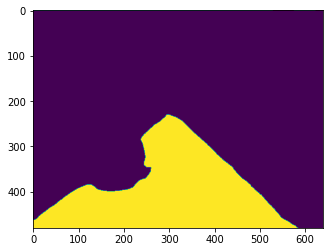

In [63]:
plt.imshow((preds>0.5)[0][0, :, :])
plt.show()

In [69]:
torch.cuda.get_device_properties(0).total_memory

11996954624

In [70]:
torch.cuda.memory_reserved(0)

10630463488

In [73]:
import pynvml

In [74]:
def get_memory_free_MiB(gpu_index):
    pynvml.nvmlInit()
    handle = pynvml.nvmlDeviceGetHandleByIndex(int(gpu_index))
    mem_info = pynvml.nvmlDeviceGetMemoryInfo(handle)
    return mem_info.free // 1024 ** 2


## Аналитическое уравнение дорожного пространства

In [64]:
mask = (preds>0.5).int().cpu().detach().numpy()

In [65]:
mask

array([[[[1, 1, 1, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [1, 1, 1, ..., 0, 0, 0],
         [1, 1, 1, ..., 0, 0, 0],
         [1, 1, 1, ..., 0, 0, 0]]]], dtype=int32)

In [85]:
mask.shape

(1, 1, 480, 640)

In [86]:
mask = mask[0][0]
mask = 255 * mask.astype(np.uint8)

In [87]:
mask.shape

(480, 640)

In [88]:
im, contours, hierarchy = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

In [89]:
contours[0].shape

(332, 1, 2)

In [90]:
image_copy = image_orig.copy()

In [91]:
cv2.drawContours(image=image_copy, contours=contours, contourIdx=-1, color=(0, 255, 0), thickness=2, lineType=cv2.LINE_AA)

array([[[  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0],
        ...,
        [ 18,  42,  28],
        [ 15,  30,  23],
        [ 10,  26,  19]],

       [[  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0],
        ...,
        [ 18,  40,  29],
        [ 15,  26,  18],
        [ 12,  23,  15]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [ 18,  37,  29],
        [ 16,  25,  17],
        [ 16,  21,  15]],

       ...,

       [[  0, 255,   0],
        [  0, 255,   0],
        [ 92,  95,  92],
        ...,
        [ 57,  99,  81],
        [ 58,  95,  88],
        [ 58, 106,  85]],

       [[  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0],
        ...,
        [ 55,  93,  78],
        [ 60,  87,  77],
        [ 63, 110,  84]],

       [[  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0],
        ...,
        [ 57,  84,  74],
        [ 59,  77,  56],
        [ 64, 103,  79]]

In [92]:
from google.colab.patches import cv2_imshow

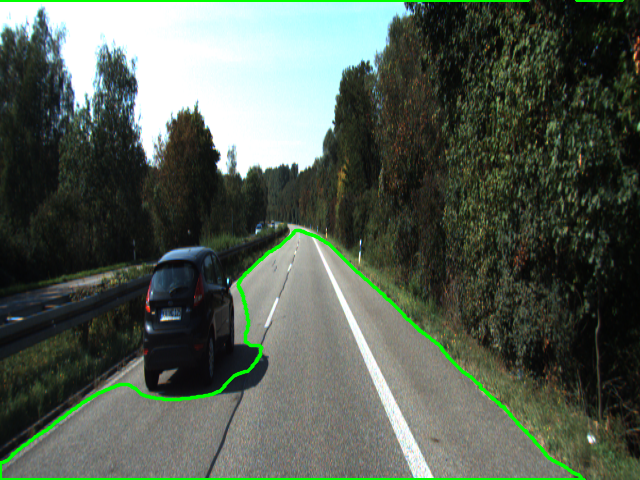

In [93]:
cv2_imshow(image_copy)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [94]:
image_copy.shape

(480, 640, 3)

In [95]:
shapes = [con.shape[0] for con in contours]

In [96]:
main_road_index = shapes.index(max(shapes))

In [97]:
contours[main_road_index] = contours[main_road_index].reshape((contours[main_road_index].shape[0], 2))

In [98]:
contours[main_road_index].shape

(332, 2)

In [99]:
import pandas as pd

In [100]:
df = pd.DataFrame(contours[main_road_index], columns = ['x', 'y'])

In [101]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

In [102]:
def PolynomialRegression(degree):
    return Pipeline([
        ('poly', PolynomialFeatures(degree=degree)),
        ('std_scaler', StandardScaler()),
        ('lin_reg', LinearRegression())
    ])

In [103]:
clf = PolynomialRegression(6)

In [104]:
X = np.array([df.loc[:, 'x'].values]).reshape(-1, 1)
y = np.array([df.loc[:, 'y'].values]).reshape(-1, 1)

In [105]:
clf.fit(X, y)

Pipeline(steps=[('poly', PolynomialFeatures(degree=6)),
                ('std_scaler', StandardScaler()),
                ('lin_reg', LinearRegression())])

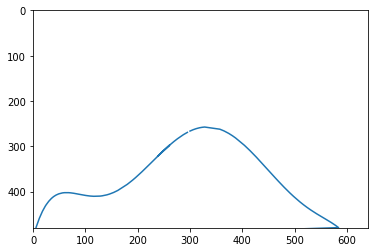

In [106]:
plt.plot(X, clf.predict(X))
ax = plt.gca()
ax.set_xlim([0, 640])
ax.set_ylim([0, 480])
plt.gca().invert_yaxis()
plt.show()

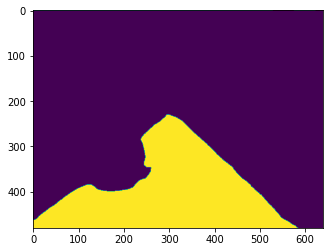

In [107]:
plt.imshow((preds>0.5)[0][0, :, :])
plt.show()

In [108]:
clf[2].coef_

array([[     0.        ,   -728.01047313,   6887.22705917,
        -25777.49548687,  42708.39003516, -32135.14095709,
          9059.69569258]])

In [109]:
clf[0].get_feature_names_out()

array(['1', 'x0', 'x0^2', 'x0^3', 'x0^4', 'x0^5', 'x0^6'], dtype=object)

In [205]:
image = cv2.imread('/content/000032_10.png')
# image_orig = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

In [206]:
image_copy = torch.unsqueeze(t_test(image = image)['image'], dim = 0)
image_orig = t_test_orig(image = image)['image']

In [207]:
image_copy = image_copy.to('cpu') 
preds = model.to('cpu').forward(image_copy)

In [208]:
def draw_segmentation_map(outputs):
    preds = (outputs > 0.5).int().cpu().detach()
    label = preds.squeeze()
    red_map = np.zeros_like(label).astype(np.uint8)
    
    red_map = np.zeros_like(label).astype(np.uint8)
    red_map[label == 1] = 255.0

    segmented_image = np.stack([red_map, np.zeros_like(label), np.zeros_like(label)], axis=2)
    return segmented_image.astype(np.uint8)

In [209]:
def image_overlay(image, segmented_image):
    alpha = 0.3 
    beta = 1 - alpha 
    gamma = 0 
    # image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    segmented_image = cv2.cvtColor(segmented_image, cv2.COLOR_RGB2BGR)
    cv2.addWeighted(segmented_image, alpha, image, beta, gamma, image)
    return image

In [210]:
segmented_image = draw_segmentation_map(preds)

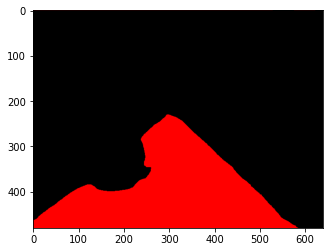

In [211]:
plt.imshow(segmented_image)
plt.show()

In [212]:
final_image = image_overlay(image_orig, segmented_image)

In [213]:
final_image.shape

(480, 640, 3)

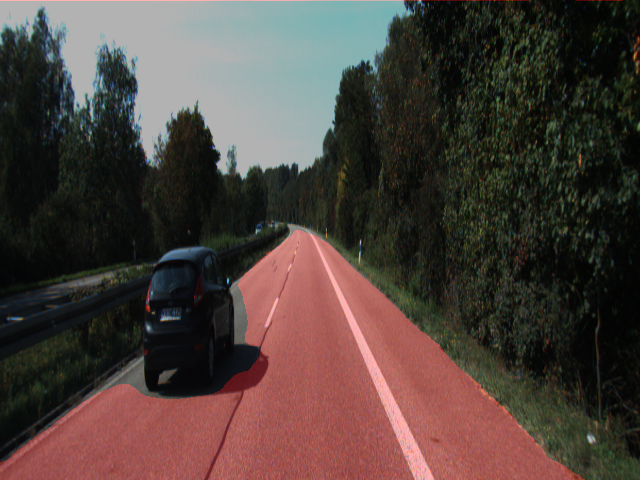

In [214]:
cv2_imshow(final_image)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [120]:
image_copy.shape

torch.Size([1, 3, 480, 640])

In [ ]:
def segment_image(path, model, poly):
  cap = cv2.VideoCapture(path)
  if (cap.isOpened() == False):
    print('Error while trying to read video. Please check path again')
  